## Canny Edge Detection Algorithm 
#### Step 1: Noise Reduction 
#### Step 2: Gradient Calculation
#### Step 3: Non-maximum Suppression
#### Step 4: Double threshold
#### Step 5: Edge tracking by Hysteresis


In [1]:
import numpy as np 
import cv2  
from matplotlib import pyplot as plt
from scipy import signal
%matplotlib inline



In [2]:
def sobel_gradient(img, edge_filter):
    """
    Gradient Calculation.
    """
    fx = signal.convolve2d(img, edge_filter)
    fy = signal.convolve2d(img, np.flip(edge_filter.T, axis=0))
    g_magnitude = np.sqrt(np.square(fx) + np.square(fy))
    # normalize in to 0 -255 scale
    g_magnitude *= 255.0/g_magnitude.max()
    g_direction = np.arctan2(fy, fx)
    # converting direction to degree. 
    g_direction = np.rad2deg(g_direction)
    #g_direction += 180
    
    return [g_magnitude, g_direction]

In [22]:
def non_maximal_suppression(g_magnitude, g_direction):
    """
    Non-maximal suppression
    Description:
    Actually, gradient magnitude operators in step 2, normally obtains thick edges, but final image 
    expected to have thin edges. 
    Non-maximal suppression enables us to drive thin edges from thick through following steps:
    
    We already have the edge direction in g_direction. The subsequent step is to relate the identified edge direction 
    to a DIRECTION that can be sketched in the image.
    
    There are 4 possible directions:
    - 0 degree
    - 45 degree
    - 95 degree
    -135 degree
    
    Hence it forces us to a situation where the edges has to be definitely oriented to one of these four directions.
    this is kind of approximation by orientation angle 5 degree to 0 degree 43degree to 45 and so on.
    O to 22.5 -------> 0 degree
    22.5 to 67.5 -----> 45 degree
    157.5 to 180 -----> 0 degree
    67.5 to 112.5 ----> 90 degree.
    112.5 to 157.5 ----> 135 degree.
    Non-maximal suppression:
    process when suppression of the pixels to zero which cannot be considered as an edge is carried out.
    this shall enable system to generate thin line in output image.
    """
    row, column = g_magnitude.shape
    output_image = np.zeros((row, column))
    
    g_direction = g_direction.reshape(1, -1)
    g_direction = np.absolute(np.squeeze(g_direction))
    
    g_direction[np.logical_and(0 < g_direction, g_direction< 22.5)] = 0
    g_direction[np.logical_and(22.5 <= g_direction, g_direction< 67.5)] = 45
    g_direction[np.logical_and(157.5 <= g_direction, g_direction< 180)] = 0
    g_direction[np.logical_and(67.5 <= g_direction, g_direction< 122.5)] = 90
    g_direction[np.logical_and(112.5 <= g_direction, g_direction< 157.5)] = 135
    
    g_direction = g_direction.reshape(row, column)
    
    # consider those pixels only which are part of edge. rest are set zero using np.zeros()
    # Todo: Convert following logic into numpy . 
    #g_magnitude[np.logical_and(g_direction==0, g_manitude>=)]
    
    
    for row in range(1, row - 1):
        for col in range(1, column - 1):
            direction = g_direction[row, col]
            
            if direction==0:
                before_pixel = g_magnitude[row, col - 1]
                after_pixel = g_magnitude[row, col + 1]

            elif direction==45:
                before_pixel = g_magnitude[row + 1, col - 1]
                after_pixel = g_magnitude[row - 1, col + 1]

            elif direction==90:
                before_pixel = g_magnitude[row - 1, col]
                after_pixel = g_magnitude[row + 1, col]

            else: # 135degree
                before_pixel = g_magnitude[row - 1, col - 1]
                after_pixel = g_magnitude[row + 1, col + 1]

            if g_magnitude[row, col] >= before_pixel and g_magnitude[row, col] >= after_pixel:
                output_image[row, col] = g_magnitude[row, col]

    return output_image

In [26]:
def canny_threshold(image, low, high, weak):
    strong = 255
    
    output = np.zeros(image.shape)
    
    strong_row, strong_col = np.where(image >= high)
    weak_row, weak_col = np.where((image <= high) & (image >= low))

    output[strong_row, strong_col] = strong
    output[weak_row, weak_col] = weak

    return output.astype(np.uint8)

In [31]:
def hysteresis(image, weak):
   
    image_row, image_col = image.shape

    # --- Scan from top-left to bottom-right ---
    tl_to_br = image.copy()
    for row in range(1, image_row):
        for col in range(1, image_col):
            if tl_to_br[row, col] == weak:
                if tl_to_br[row, col + 1] == 255 or tl_to_br[row, col - 1] == 255 or tl_to_br[row - 1, col] == 255 or tl_to_br[
                    row + 1, col] == 255 or tl_to_br[row - 1, col - 1] == 255 or tl_to_br[row + 1, col - 1] == 255 or tl_to_br[
                    row - 1, col + 1] == 255 or tl_to_br[row + 1, col + 1] == 255:
                    tl_to_br[row, col] = 255
                else:
                    tl_to_br[row, col] = 0

    # --- Scan from bottom-right to top-left ---
    br_to_tl = image.copy()
    for row in range(image_row - 1, 0, -1):
        for col in range(image_col - 1, 0, -1):
            if br_to_tl[row, col] == weak:
                if br_to_tl[row, col + 1] == 255 or br_to_tl[row, col - 1] == 255 or br_to_tl[row - 1, col] == 255 or br_to_tl[
                    row + 1, col] == 255 or br_to_tl[row - 1, col - 1] == 255 or br_to_tl[row + 1, col - 1] == 255 or br_to_tl[
                    row - 1, col + 1] == 255 or br_to_tl[row + 1, col + 1] == 255:
                    br_to_tl[row, col] = 255
                else:
                    br_to_tl[row, col] = 0

    # --- Scan from top-right to bottom-left ---
    tr_to_bl = image.copy()
    for row in range(1, image_row):
        for col in range(image_col - 1, 0, -1):
            if tr_to_bl[row, col] == weak:
                if tr_to_bl[row, col + 1] == 255 or tr_to_bl[row, col - 1] == 255 or tr_to_bl[row - 1, col] == 255 or tr_to_bl[
                    row + 1, col] == 255 or tr_to_bl[row - 1, col - 1] == 255 or tr_to_bl[row + 1, col - 1] == 255 or tr_to_bl[
                    row - 1, col + 1] == 255 or tr_to_bl[row + 1, col + 1] == 255:
                    tr_to_bl[row, col] = 255
                else:
                    tr_to_bl[row, col] = 0

    # --- Scan from bottom-left to top-right ---
    bl_to_tr = image.copy()
    for row in range(image_row - 1, 0, -1):
        for col in range(1, image_col):
            if bl_to_tr[row, col] == weak:
                if bl_to_tr[row, col + 1] == 255 or bl_to_tr[row, col - 1] == 255 or bl_to_tr[row - 1, col] == 255 or bl_to_tr[
                    row + 1, col] == 255 or bl_to_tr[row - 1, col - 1] == 255 or bl_to_tr[row + 1, col - 1] == 255 or bl_to_tr[
                    row - 1, col + 1] == 255 or bl_to_tr[row + 1, col + 1] == 255:
                    bl_to_tr[row, col] = 255
                else:
                    bl_to_tr[row, col] = 0

    final_image = tl_to_br + br_to_tl + tr_to_bl + bl_to_tr

    final_image[final_image > 255] = 255

    return final_image

(<matplotlib.axes._subplots.AxesSubplot at 0x1c2f2ba350>,
 <matplotlib.image.AxesImage at 0x1c2a609710>)

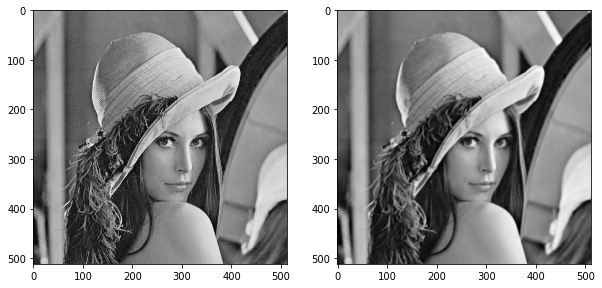

In [32]:
img = cv2.imread('./images/lena.jpg', 0)
#print(img)
# step 1:Image smoothing
smooth_img = cv2.GaussianBlur(img, (5,5), 0)
# step 2: Gradient calculation using sobel operator 
edge_filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
g_magnitude, g_direction = sobel_gradient(smooth_img, edge_filter)
# step 3: Non maximal suppression:
edgeImg = non_maximal_suppression(g_magnitude, g_direction)
# step 4: Double Thresholding:
weak = 50
thrdImg = canny_threshold(edgeImg, 5, 20, weak)
#step 5: Edge Tracking by Hysteresis:
cannyImg = hysteresis(thrdImg, weak)
#############
plt.figure(figsize = (10,5))
plt.subplot(121), plt.imshow(img, cmap="gray")
plt.subplot(122), plt.imshow(smooth_img, cmap="gray")

(<matplotlib.axes._subplots.AxesSubplot at 0x1c26b4e710>,
 <matplotlib.image.AxesImage at 0x1c2e32c8d0>)

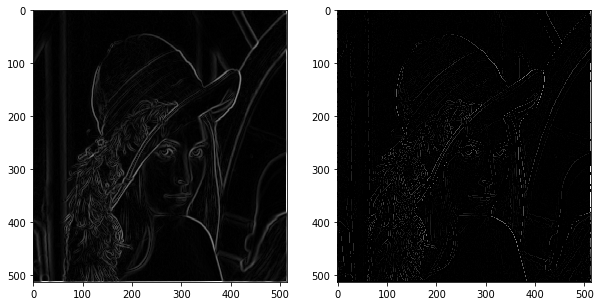

In [34]:
# before and after non-maximum subpression :
plt.figure(figsize = (10,5))
plt.subplot(121), plt.imshow(g_magnitude, cmap="gray", aspect='auto')
plt.subplot(122), plt.imshow(edgeImg, cmap="gray", aspect='auto')


(<matplotlib.axes._subplots.AxesSubplot at 0x1c2ed97a10>,
 <matplotlib.image.AxesImage at 0x1c2f8c2190>)

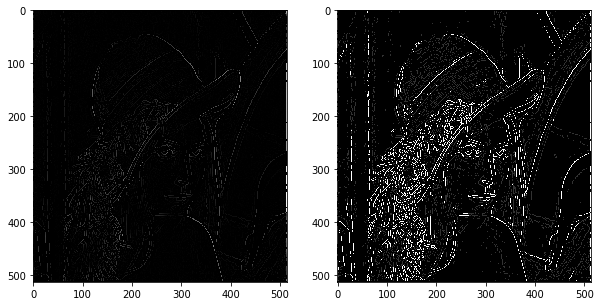

In [35]:
# before and after canny_threshold :
plt.figure(figsize = (10,5))
plt.subplot(121), plt.imshow(edgeImg, cmap="gray", aspect='auto')
plt.subplot(122), plt.imshow(thrdImg, cmap="gray", aspect='auto')

(<matplotlib.axes._subplots.AxesSubplot at 0x1c2d59f590>,
 <matplotlib.image.AxesImage at 0x1c26ade050>)

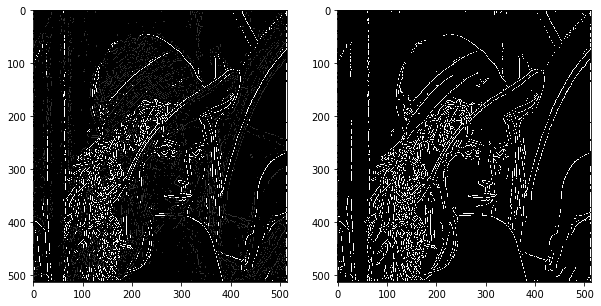

In [36]:
# before and after canny_threshold :
plt.figure(figsize = (10,5))
plt.subplot(121), plt.imshow(thrdImg, cmap="gray", aspect='auto')
plt.subplot(122), plt.imshow(cannyImg, cmap="gray", aspect='auto')